In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/custom-fine-funed-2/keras/default/1/fine_tuned_model2.keras
/kaggle/input/brain-tumor-mris/brain_tumor_mris/Validation/pituitary/Tr-pi_1274.jpg
/kaggle/input/brain-tumor-mris/brain_tumor_mris/Validation/pituitary/Tr-pi_1271.jpg
/kaggle/input/brain-tumor-mris/brain_tumor_mris/Validation/pituitary/Tr-pi_1283.jpg
/kaggle/input/brain-tumor-mris/brain_tumor_mris/Validation/pituitary/Tr-pi_1204.jpg
/kaggle/input/brain-tumor-mris/brain_tumor_mris/Validation/pituitary/Tr-pi_1200.jpg
/kaggle/input/brain-tumor-mris/brain_tumor_mris/Validation/pituitary/Tr-pi_1310.jpg
/kaggle/input/brain-tumor-mris/brain_tumor_mris/Validation/pituitary/Tr-pi_1299.jpg
/kaggle/input/brain-tumor-mris/brain_tumor_mris/Validation/pituitary/Tr-pi_1202.jpg
/kaggle/input/brain-tumor-mris/brain_tumor_mris/Validation/pituitary/Tr-pi_1276.jpg
/kaggle/input/brain-tumor-mris/brain_tumor_mris/Validation/pituitary/Tr-pi_1225.jpg
/kaggle/input/brain-tumor-mris/brain_tumor_mris/Validation/pituitary/Tr-pi_1217.jpg
/k

In [3]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Flatten, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import os


In [4]:
train_dir = "/kaggle/input/brain-tumor-mris/brain_tumor_mris/Training"
val_dir = "/kaggle/input/brain-tumor-mris/brain_tumor_mris/Validation"
test_dir = "/kaggle/input/brain-tumor-mris/brain_tumor_mris/Testing"


In [5]:
import matplotlib.pyplot as plt
import numpy as np
import os
from tensorflow.keras.preprocessing.image import load_img, img_to_array


In [6]:
# Get the class names (folder names)
class_names = sorted(os.listdir(train_dir))
print("Classes:", class_names)

# Dictionary to store one image path from each class
image_paths = {class_name: os.path.join(train_dir, class_name, os.listdir(os.path.join(train_dir, class_name))[0])
               for class_name in class_names}


Classes: ['glioma', 'meningioma', 'notumor', 'pituitary']


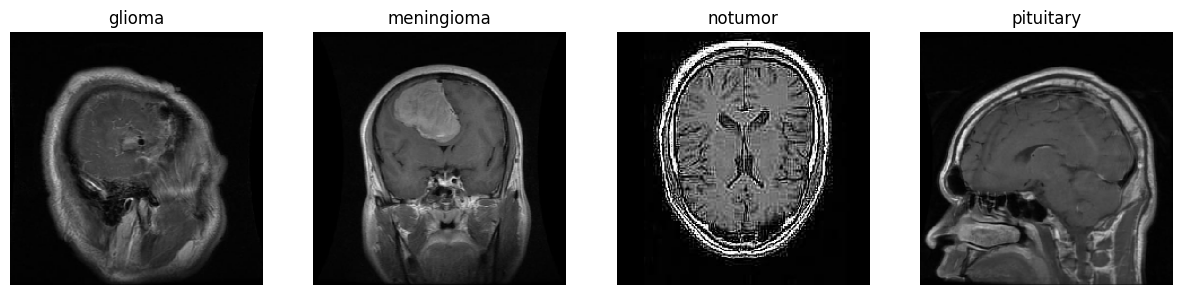

In [7]:
fig, axes = plt.subplots(1, len(class_names), figsize=(15, 5))

for ax, (class_name, image_path) in zip(axes, image_paths.items()):
    img = load_img(image_path, target_size=(224, 224))  # Load image
    ax.imshow(img)
    ax.set_title(class_name)
    ax.axis("off")  # Hide axis

plt.show()


**Data Augmentation**

In [8]:
from tensorflow import keras
from tensorflow.keras import layers

In [9]:
img_height = 224
img_width = 224
batch_size = 32

In [10]:
img_size = (img_height, img_width)

In [11]:
import keras
data_augmentation = keras.Sequential(
[
    layers.RandomFlip("horizontal",
                     input_shape=(img_height,
                                 img_width,
                                  3)),

    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1)
])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [12]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Data Augmentation for Training Data
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal", input_shape=(img_height, img_width, 3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1)
])

# Training Data Generator with Augmentation
train_datagen = ImageDataGenerator(
    rescale=1.0/255,  # Normalize pixel values
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True
)

# Validation & Testing Data Generators (Only Rescaling)
val_test_datagen = ImageDataGenerator(rescale=1.0/255)

# Load Training Images
train_generator = train_datagen.flow_from_directory(
    train_dir, target_size=(img_height, img_width), batch_size=batch_size, class_mode='categorical'
)

# Load Validation Images
val_generator = val_test_datagen.flow_from_directory(
    val_dir, target_size=(img_height, img_width), batch_size=batch_size, class_mode='categorical'
)

# Load Testing Images (Without Shuffling for Consistent Predictions)
test_generator = val_test_datagen.flow_from_directory(
    test_dir, target_size=(img_height, img_width), batch_size=batch_size, class_mode='categorical', shuffle=False
)


Found 4672 images belonging to 4 classes.
Found 576 images belonging to 4 classes.
Found 576 images belonging to 4 classes.


Classes: ['glioma', 'meningioma', 'notumor', 'pituitary']


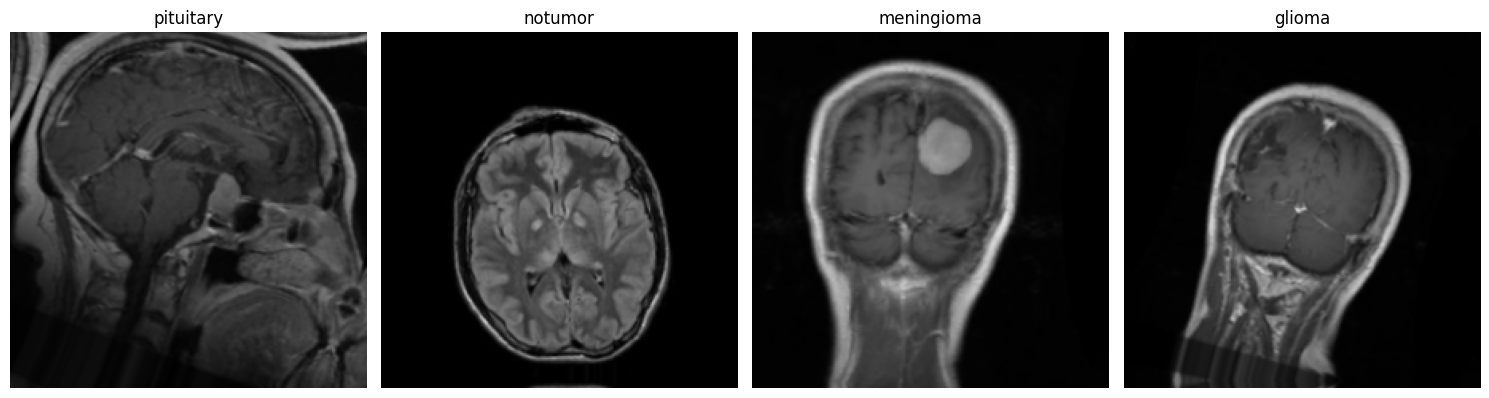

In [13]:
# Get class names
class_names = list(train_generator.class_indices.keys())
print("Classes:", class_names)

# Initialize plot
fig, axes = plt.subplots(1, len(class_names), figsize=(15, 5))

# Dictionary to store one augmented image per class
displayed_classes = set()

# Iterate through the dataset to find one image per class
for images, labels in train_generator:
    for i in range(len(labels)):
        class_index = np.argmax(labels[i])  # Get class index
        class_name = class_names[class_index]

        if class_name not in displayed_classes:
            # Apply augmentation
            augmented_img = data_augmentation(tf.expand_dims(images[i], axis=0))

            # Display image
            axes[len(displayed_classes)].imshow(augmented_img[0])
            axes[len(displayed_classes)].set_title(class_name)
            axes[len(displayed_classes)].axis("off")

            displayed_classes.add(class_name)

        if len(displayed_classes) == len(class_names):  # Stop when all classes are covered
            break
    if len(displayed_classes) == len(class_names):
        break

plt.tight_layout()
plt.show()


**Fine-tuning 2**

In [14]:
import tensorflow as tf
from tensorflow.keras import layers, regularizers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

In [16]:
# Load the previously trained model
model = tf.keras.models.load_model('/kaggle/input/custom-fine-funed-2/keras/default/1/fine_tuned_model2.keras')

In [17]:
# Set a lower learning rate for fine-tuning
fine_tune_lr = 5e-6

In [18]:
# Compile the model with a lower learning rate
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=fine_tune_lr),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [19]:
early_stopping = EarlyStopping(
    monitor="val_loss",
    patience=10,
    restore_best_weights=True,
    verbose=1
)

model_checkpoint = ModelCheckpoint(
    filepath="fine_tuned_model3.keras",
    monitor="val_loss",
    save_best_only=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.5,
    patience=5,
    min_lr=1e-7,
    verbose=1
)

In [21]:
# Fine-tune the model again
history = model.fit(
    train_generator,
    epochs=50,  # Fewer epochs for fine-tuning
    validation_data=val_generator,
    callbacks=[early_stopping, model_checkpoint, reduce_lr]
)

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 536ms/step - accuracy: 0.9945 - loss: 0.1226
Epoch 1: val_loss improved from inf to 0.37684, saving model to fine_tuned_model3.keras
146/146 ━━━━━━━━━━━━━━━━━━━━ 117s 620ms/step - accuracy: 0.9945 - loss: 0.1226 - val_accuracy: 0.9375 - val_loss: 0.3768 - learning_rate: 5.0000e-06
Epoch 2/50
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 348ms/step - accuracy: 0.9948 - loss: 0.1122
Epoch 2: val_loss did not improve from 0.37684
146/146 ━━━━━━━━━━━━━━━━━━━━ 55s 361ms/step - accuracy: 0.9948 - loss: 0.1122 - val_accuracy: 0.9306 - val_loss: 0.3918 - learning_rate: 5.0000e-06
Epoch 3/50
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 345ms/step - accuracy: 0.9948 - loss: 0.1098
Epoch 3: val_loss improved from 0.37684 to 0.37259, saving model to fine_tuned_model3.keras
146/146 ━━━━━━━━━━━━━━━━━━━━ 59s 384ms/step - accuracy: 0.9948 - loss: 0.1098 - val_accuracy: 0.9410 - val_loss: 0.3726 - learning_rate: 5.0000e-06
Epoch 4/50
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 351ms/step - accuracy: 0.9941 - 

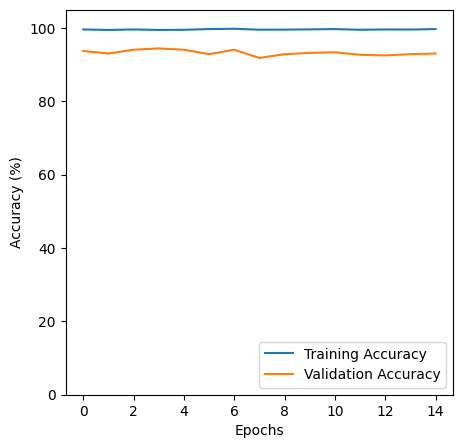

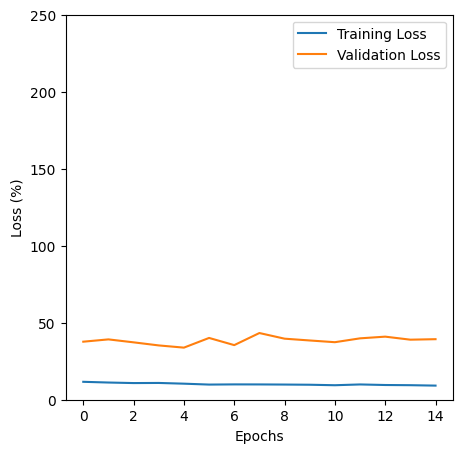

In [22]:
import matplotlib.pyplot as plt

# Extract training and validation metrics
acc = [a * 100 for a in history.history['accuracy']]
val_acc = [a * 100 for a in history.history['val_accuracy']]
loss = [b * 100 for b in history.history['loss']]
val_loss = [b * 100 for b in history.history['val_loss']]
epochs_range = range(len(acc))

# Plot Training & Validation Accuracy
plt.figure(figsize=(5, 5))
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
#plt.title("Training & Validation Accuracy")
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.ylim([0, 105])  # Ensure values stay within range
#plt.grid(True, linestyle='--', alpha=0.5)  # Add grid lines for better visualization
plt.savefig('Fine-Tuned_Custom3_200_training_validation_accuracy.png')
plt.show()

# Plot Training & Validation Loss
plt.figure(figsize=(5, 5))
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
#plt.title('Training & Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss (%)')
plt.ylim([0, 250])
#plt.grid(True, linestyle='--', alpha=0.5)
plt.savefig('Fine-Tuned_Custom3_200_training_validation_loss.png')
plt.show()


In [23]:
model.evaluate(train_generator) # Training accuracy and loss

146/146 ━━━━━━━━━━━━━━━━━━━━ 52s 353ms/step - accuracy: 0.9989 - loss: 0.0940


[0.09489114582538605, 0.998501718044281]

In [24]:
model.evaluate(val_generator) # Validation accuracy and loss

18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 95ms/step - accuracy: 0.9315 - loss: 0.3785


[0.33823996782302856, 0.9409722089767456]

In [26]:
model.evaluate(test_generator) # Testing accuracy and loss

18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 95ms/step - accuracy: 0.9932 - loss: 0.1187


[0.11833970993757248, 0.9930555820465088]

In [27]:
num_classes = 4

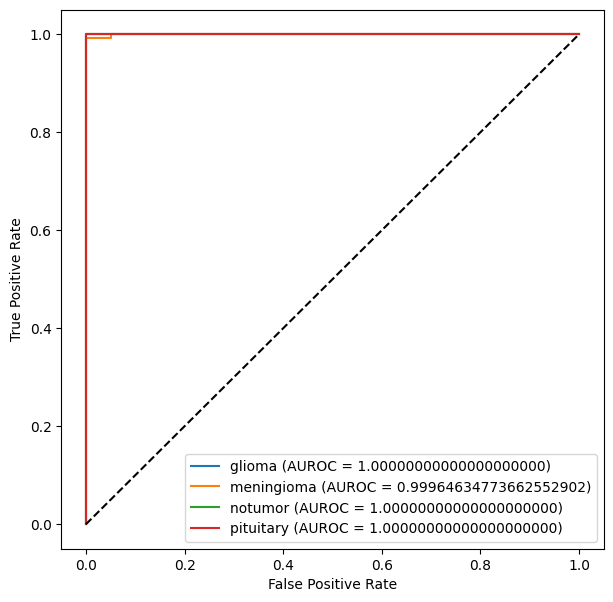

In [28]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

# Get true labels and one-hot encode them
y_true = test_generator.classes  # True labels from test set
y_true_binarized = label_binarize(y_true, classes=np.arange(num_classes))

# Predict probabilities in one step (faster execution)
y_pred_probs = model.predict(test_generator, verbose=0)

# Create figure for ROC curves
plt.figure(figsize=(7, 7))

# Compute and plot ROC curve for each class
for i in range(num_classes):
    fpr, tpr, _ = roc_curve(y_true_binarized[:, i], y_pred_probs[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{class_names[i]} (AUROC = {roc_auc:.20f})')

# Formatting
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
#plt.grid(True, linestyle='--', alpha=0.6)

# Save and display the AUROC plot
plt.savefig('Fine-Tuned_Custom3_AUROC.png', dpi=300, bbox_inches='tight')
plt.show()


In [29]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import numpy as np

# Get true labels and one-hot encode them
y_true = test_generator.classes  # True labels from test set
y_true_binarized = label_binarize(y_true, classes=np.arange(num_classes))

# Predict probabilities
y_pred_probs = model.predict(test_generator, verbose=0)

# Compute AUROC for each class
auroc_values = []
for i in range(num_classes):
    fpr, tpr, _ = roc_curve(y_true_binarized[:, i], y_pred_probs[:, i])
    roc_auc = auc(fpr, tpr)  # Compute AUROC
    auroc_values.append(roc_auc)

# Print exact AUROC values (no rounding)
print("AUROC values for each class:", auroc_values)


AUROC values for each class: [1.0, 0.9996463477366255, 1.0, 1.0]


In [30]:
from sklearn.metrics import classification_report, confusion_matrix

# y_true is already in label format, so don't apply argmax
y_true_classes = y_true  # No need for np.argmax
y_pred_classes = np.argmax(y_pred_probs, axis=1)  # Convert probabilities to class labels

# Generate classification report and confusion matrix
print(classification_report(y_true_classes, y_pred_classes, target_names=class_names))
print(confusion_matrix(y_true_classes, y_pred_classes))


              precision    recall  f1-score   support

      glioma       1.00      1.00      1.00       144
  meningioma       1.00      0.97      0.99       144
     notumor       0.98      1.00      0.99       144
   pituitary       0.99      1.00      1.00       144

    accuracy                           0.99       576
   macro avg       0.99      0.99      0.99       576
weighted avg       0.99      0.99      0.99       576

[[144   0   0   0]
 [  0 140   3   1]
 [  0   0 144   0]
 [  0   0   0 144]]


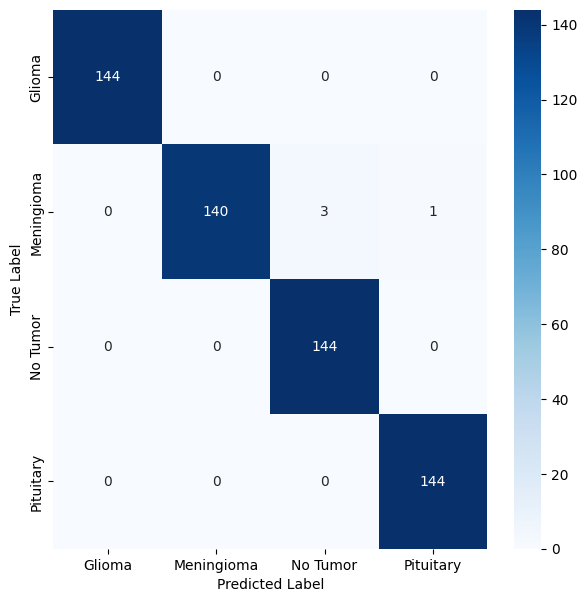

In [31]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Compute confusion matrix
cm = confusion_matrix(y_true, np.argmax(y_pred_probs, axis=1))

# Define class names (Modify as per your dataset)
class_names = ['Glioma', 'Meningioma', 'No Tumor', 'Pituitary']

# Plot confusion matrix
plt.figure(figsize=(7, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)

# Formatting
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
#plt.title('Confusion Matrix')

# Save the confusion matrix as an image
plt.savefig('Fine-Tuned_Custom3_200_confusion_matrix.png', dpi=300, bbox_inches='tight')

# Show the plot
plt.show()


In [32]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 112, 112, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 56, 56, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 28, 28, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 14, 14, 512)         │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 100352)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │      51,380,736 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 166,311,502 (634.43 MB)

 Trainable params: 55,054,596 (210.02 MB)

 Non-trainable params: 1,147,712 (4.38 MB)

 Optimizer params: 110,109,194 (420.03 MB)

**Explainable AI**

**Occlusion Sensitivity**

In [33]:
IMG_SIZE = (224, 224)

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━

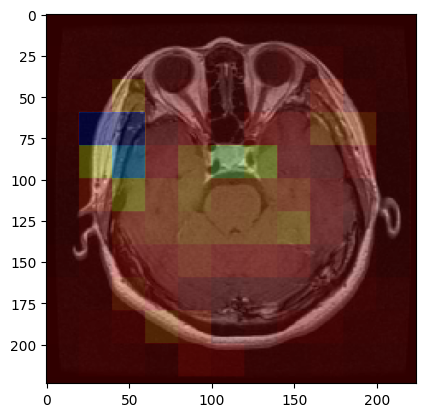

In [34]:
def occlusion_sensitivity(img_path, model, patch_size=20):
    img = keras.preprocessing.image.load_img(img_path, target_size=IMG_SIZE)
    img_array = keras.preprocessing.image.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    occlusion_map = np.zeros_like(img_array[0, :, :, 0])

    for i in range(0, IMG_SIZE[0], patch_size):
        for j in range(0, IMG_SIZE[1], patch_size):
            occluded_img = img_array.copy()
            occluded_img[0, i:i+patch_size, j:j+patch_size, :] = 0

            prediction = model.predict(occluded_img)
            class_idx = np.argmax(prediction[0])

            occlusion_map[i:i+patch_size, j:j+patch_size] = prediction[0][class_idx]

    plt.imshow(img)
    plt.imshow(occlusion_map, cmap='jet', alpha=0.3)
    plt.show()

# Run Occlusion Sensitivity
occlusion_sensitivity("/kaggle/input/brain-tumor-mris/brain_tumor_mris/Testing/pituitary/Te-pi_0011.jpg", model)


**LIME**

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━

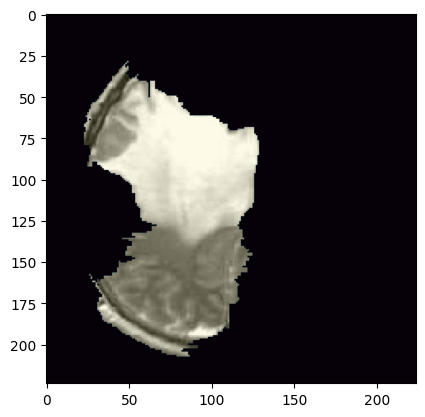

In [35]:
from lime import lime_image

def explain_lime(img_path, model):
    img = keras.preprocessing.image.load_img(img_path, target_size=IMG_SIZE)
    img_array = keras.preprocessing.image.img_to_array(img) / 255.0

    explainer = lime_image.LimeImageExplainer()
    explanation = explainer.explain_instance(
        img_array.astype('double'),
        model.predict,
        top_labels=5,
        hide_color=0,
        num_samples=1000
    )

    temp, mask = explanation.get_image_and_mask(
        explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=True
    )

    plt.imshow(temp)
    plt.imshow(mask, alpha=0.1)
    plt.show()

explain_lime("/kaggle/input/brain-tumor-mris/brain_tumor_mris/Testing/meningioma/Te-me_0036.jpg", model)

In [37]:
img_path = "/kaggle/input/brain-tumor-mris/brain_tumor_mris/Testing/meningioma/Te-me_0036.jpg"

**SmoothGrad**

In [ ]:
# ValueError: 'red' is not a valid value for cmap; supported values are 'Accent', 'Accent_r', 'Blues', 'Blues_r', 'BrBG', 'BrBG_r', 'BuGn', 'BuGn_r', 'BuPu', 'BuPu_r', 'CMRmap', 'CMRmap_r', 'Dark2', 'Dark2_r', 'GnBu', 'GnBu_r', 'Greens', 'Greens_r', 'Greys', 'Greys_r', 'OrRd', 'OrRd_r', 'Oranges', 'Oranges_r', 'PRGn', 'PRGn_r', 'Paired', 'Paired_r', 'Pastel1', 'Pastel1_r', 'Pastel2', 'Pastel2_r', 'PiYG', 'PiYG_r', 'PuBu', 'PuBuGn', 'PuBuGn_r', 'PuBu_r', 'PuOr', 'PuOr_r', 'PuRd', 'PuRd_r', 'Purples', 'Purples_r', 'RdBu', 'RdBu_r', 'RdGy', 'RdGy_r', 'RdPu', 'RdPu_r', 'RdYlBu', 'RdYlBu_r', 'RdYlGn', 'RdYlGn_r', 'Reds', 'Reds_r', 'Set1', 'Set1_r', 'Set2', 'Set2_r', 'Set3', 'Set3_r', 'Spectral', 'Spectral_r', 'Wistia', 'Wistia_r', 'YlGn', 'YlGnBu', 'YlGnBu_r', 'YlGn_r', 'YlOrBr', 'YlOrBr_r', 'YlOrRd', 'YlOrRd_r', 'afmhot', 'afmhot_r', 'autumn', 'autumn_r', 'binary', 'binary_r', 'bone', 'bone_r', 'brg', 'brg_r', 'bwr', 'bwr_r', 'cividis', 'cividis_r', 'cool', 'cool_r', 'coolwarm', 'coolwarm_r', 'copper', 'copper_r', 'crest', 'crest_r', 'cubehelix', 'cubehelix_r', 'flag', 'flag_r', 'flare', 'flare_r', 'gist_earth', 'gist_earth_r', 'gist_gray', 'gist_gray_r', 'gist_heat', 'gist_heat_r', 'gist_ncar', 'gist_ncar_r', 'gist_rainbow', 'gist_rainbow_r', 'gist_stern', 'gist_stern_r', 'gist_yarg', 'gist_yarg_r', 'gnuplot', 'gnuplot2', 'gnuplot2_r', 'gnuplot_r', 'gray', 'gray_r', 'hot', 'hot_r', 'hsv', 'hsv_r', 'icefire', 'icefire_r', 'inferno', 'inferno_r', 'jet', 'jet_r', 'magma', 'magma_r', 'mako', 'mako_r', 'nipy_spectral', 'nipy_spectral_r', 'ocean', 'ocean_r', 'pink', 'pink_r', 'plasma', 'plasma_r', 'prism', 'prism_r', 'rainbow', 'rainbow_r', 'rocket', 'rocket_r', 'seismic', 'seismic_r', 'spring', 'spring_r', 'summer', 'summer_r', 'tab10', 'tab10_r', 'tab20', 'tab20_r', 'tab20b', 'tab20b_r', 'tab20c', 'tab20c_r', 'terrain', 'terrain_r', 'turbo', 'turbo_r', 'twilight', 'twilight_r', 'twilight_shifted', 'twilight_shifted_r', 'viridis', 'viridis_r', 'vlag', 'vlag_r', 'winter', 'winter_r'

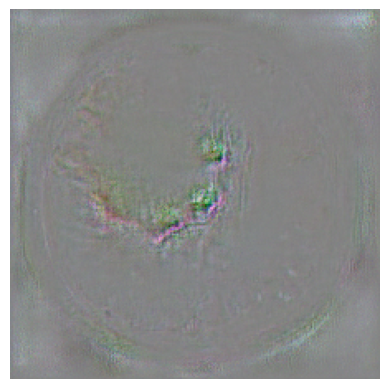

In [49]:
import tensorflow as tf

def smoothgrad(model, img_path, num_samples=50, noise_level=0.1):
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0) / 255.0

    smooth_grad = np.zeros_like(img_array)

    for _ in range(num_samples):
        noise = np.random.normal(scale=noise_level, size=img_array.shape)
        noisy_img = img_array + noise

        with tf.GradientTape() as tape:
            noisy_img = tf.convert_to_tensor(noisy_img, dtype=tf.float32)
            tape.watch(noisy_img)
            predictions = model(noisy_img)
            class_idx = np.argmax(predictions[0])
            loss = predictions[:, class_idx]

        grads = tape.gradient(loss, noisy_img)
        smooth_grad += grads.numpy()

    smooth_grad /= num_samples
    smooth_grad = np.squeeze(smooth_grad)
    smooth_grad = (smooth_grad - smooth_grad.min()) / (smooth_grad.max() - smooth_grad.min())

    plt.imshow(smooth_grad, cmap="Blues_r")
    plt.axis("off")
    plt.show()

# Run SmoothGrad
smoothgrad(model, img_path)


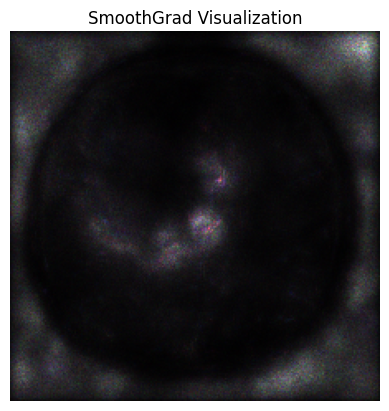

In [72]:
import tensorflow as tf
import numpy as np
import cv2
import matplotlib.pyplot as plt


# Function to preprocess image for model input
def preprocess_image(img_path):
    img = cv2.imread(img_path)
    img = cv2.resize(img, (224, 224))  # Resize to model's input size
    img = img.astype(np.float32) / 255.0  # Normalize
    img = np.expand_dims(img, axis=0)  # Add batch dimension
    return img

# Function to add Gaussian noise
def add_noise(image, noise_level=0.1):
    noise = np.random.normal(scale=noise_level, size=image.shape)
    noisy_image = np.clip(image + noise, 0, 1)
    return noisy_image

# **SmoothGrad Implementation**
def smoothgrad(model, img_path, num_samples=50, noise_level=0.1):
    img = preprocess_image(img_path)

    accumulated_gradients = np.zeros_like(img)  # Initialize accumulation

    for i in range(num_samples):
        noisy_img = add_noise(img, noise_level)
        noisy_img = tf.convert_to_tensor(noisy_img)  # Convert to tensor

        with tf.GradientTape() as tape:
            tape.watch(noisy_img)  # Track gradients
            predictions = model(noisy_img)
            class_idx = np.argmax(predictions[0])  # Get predicted class
            loss = predictions[:, class_idx]  # Focus on that class

        gradients = tape.gradient(loss, noisy_img)  # Compute gradient
        gradients = tf.abs(gradients).numpy()  # Take absolute value
        accumulated_gradients += gradients  # Sum over iterations

    averaged_grad = accumulated_gradients / num_samples  # Average gradients
    return averaged_grad[0]  # Remove batch dimension

# **Normalize SmoothGrad output**
def normalize(image):
    image -= image.min()  # Shift to 0
    image /= image.max()  # Scale to 1
    return image

# **Run SmoothGrad**
smoothgrad_output = smoothgrad(model, img_path)

if smoothgrad_output is not None:
    smoothgrad_output = normalize(smoothgrad_output)
    plt.imshow(smoothgrad_output, cmap="icefire")  # Heatmap effect
    plt.axis("off")
    plt.title("SmoothGrad Visualization")
    plt.show()
else:
    print("Error: smoothgrad() returned None")


**Saliency Maps**

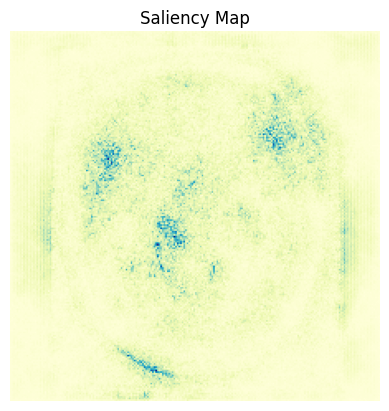

In [71]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image

def compute_saliency(model, img_path):
    # Load and preprocess image
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img) / 255.0  # Normalize
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

    # Convert to Tensor
    img_tensor = tf.convert_to_tensor(img_array, dtype=tf.float32)

    # Watch gradients w.r.t. input
    with tf.GradientTape() as tape:
        tape.watch(img_tensor)
        predictions = model(img_tensor)
        class_idx = tf.argmax(predictions[0])  # Get predicted class
        loss = predictions[:, class_idx]  # Focus on the predicted class score

    # Compute gradients
    gradients = tape.gradient(loss, img_tensor)

    # Reduce along color channels
    saliency = tf.reduce_max(tf.abs(gradients), axis=-1)[0]  # Shape: (224, 224)

    # Normalize for better visualization
    saliency = (saliency - tf.reduce_min(saliency)) / (tf.reduce_max(saliency) - tf.reduce_min(saliency))

    # Display Saliency Map
    plt.imshow(saliency, cmap="YlGnBu")
    plt.axis("off")
    plt.title("Saliency Map")
    plt.show()


# Run Saliency Map computation
compute_saliency(model, "/kaggle/input/brain-tumor-mris/brain_tumor_mris/Testing/pituitary/Te-pi_0018.jpg")


In [ ]:
# ValueError: 'red' is not a valid value for cmap; supported values are 'Accent', 'Accent_r', 'Blues', 'Blues_r', 'BrBG', 'BrBG_r', 'BuGn', 'BuGn_r', 'BuPu', 'BuPu_r', 'CMRmap', 'CMRmap_r', 'Dark2', 'Dark2_r', 'GnBu', 'GnBu_r', 'Greens', 'Greens_r', 'Greys', 'Greys_r', 'OrRd', 'OrRd_r', 'Oranges', 'Oranges_r', 'PRGn', 'PRGn_r', 'Paired', 'Paired_r', 'Pastel1', 'Pastel1_r', 'Pastel2', 'Pastel2_r', 'PiYG', 'PiYG_r', 'PuBu', 'PuBuGn', 'PuBuGn_r', 'PuBu_r', 'PuOr', 'PuOr_r', 'PuRd', 'PuRd_r', 'Purples', 'Purples_r', 'RdBu', 'RdBu_r', 'RdGy', 'RdGy_r', 'RdPu', 'RdPu_r', 'RdYlBu', 'RdYlBu_r', 'RdYlGn', 'RdYlGn_r', 'Reds', 'Reds_r', 'Set1', 'Set1_r', 'Set2', 'Set2_r', 'Set3', 'Set3_r', 'Spectral', 'Spectral_r', 'Wistia', 'Wistia_r', 'YlGn', 'YlGnBu', 'YlGnBu_r', 'YlGn_r', 'YlOrBr', 'YlOrBr_r', 'YlOrRd', 'YlOrRd_r', 'afmhot', 'afmhot_r', 'autumn', 'autumn_r', 'binary', 'binary_r', 'bone', 'bone_r', 'brg', 'brg_r', 'bwr', 'bwr_r', 'cividis', 'cividis_r', 'cool', 'cool_r', 'coolwarm', 'coolwarm_r', 'copper', 'copper_r', 'crest', 'crest_r', 'cubehelix', 'cubehelix_r', 'flag', 'flag_r', 'flare', 'flare_r', 'gist_earth', 'gist_earth_r', 'gist_gray', 'gist_gray_r', 'gist_heat', 'gist_heat_r', 'gist_ncar', 'gist_ncar_r', 'gist_rainbow', 'gist_rainbow_r', 'gist_stern', 'gist_stern_r', 'gist_yarg', 'gist_yarg_r', 'gnuplot', 'gnuplot2', 'gnuplot2_r', 'gnuplot_r', 'gray', 'gray_r', 'hot', 'hot_r', 'hsv', 'hsv_r', 'icefire', 'icefire_r', 'inferno', 'inferno_r', 'jet', 'jet_r', 'magma', 'magma_r', 'mako', 'mako_r', 'nipy_spectral', 'nipy_spectral_r', 'ocean', 'ocean_r', 'pink', 'pink_r', 'plasma', 'plasma_r', 'prism', 'prism_r', 'rainbow', 'rainbow_r', 'rocket', 'rocket_r', 'seismic', 'seismic_r', 'spring', 'spring_r', 'summer', 'summer_r', 'tab10', 'tab10_r', 'tab20', 'tab20_r', 'tab20b', 'tab20b_r', 'tab20c', 'tab20c_r', 'terrain', 'terrain_r', 'turbo', 'turbo_r', 'twilight', 'twilight_r', 'twilight_shifted', 'twilight_shifted_r', 'viridis', 'viridis_r', 'vlag', 'vlag_r', 'winter', 'winter_r'